# 海面水温

海洋は地球表面の約7割を占め，大気と相互作用をしています。特に海面水温は，下面境界条件として気象に大きな影響を与え，その偏差は異常天候の要因の一つです。気象庁の高解像度海面水温データMGDSSTを可視化してみましょう。
MGDSSTは[NEAR-GOOS RRTDB](https://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product)から提供されています。

[Readme](http://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product/mgd_sst_glb_D/Readme_mgd_sst_glb_D)によると，ファイルは日別に提供されており，解像度は0.25度です。721行からなり最初の行はデータの日，月，年，行と列の数が記されています。2行目の1列目が東経0.125度, 北緯89.875度で，721行目の1440列目が東経359.875度, 南緯89.875度おける値を表しています。つまりデータは北から南に，グリニッジ子午線から東向き並んでいます。

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr


nlon, nlat = 1440, 720
lon = np.linspace(0.125, 359.875, nlon)
lat = np.linspace(89.875, -89.875, nlat)

In [2]:
year = 2021
month = 7
day = 22
fname = f"mgd_sst_glb_D{year}{month:02}{day:02}.txt.gz"
url = f"https://www.data.jma.go.jp/gmd/goos/data/pub/JMA-product/mgd_sst_glb_D/{year}/{fname}"
with requests.get(url) as response:
    with open(fname, "wb") as f:
        f.write(response.content)

```{note}
Pythonの`requests`の代わりにシェルの`curl`コマンドを使うこともできます。
```

In [ ]:
!curl -O $url

pandasで表形式のテキストファイルを読む場合は`read_csv()`を使うことが多いのですが，MGDSSTの各要素は長さ3文字の固定長になので`pandas.read_fwf()`を使います。ヘッダ行を`skiprows`で一つ読み飛ばし，ヘッダ行なし（`header=None`）で180行（nrows=nlat）読みます。`888`と`999`はそれぞれ海氷と陸を表しているので非数とします。ただし2019年以前の再解析データ（ファイル名`re_mgd_sst_glb_Dyyyymmdd.txt.gz`）には，`888`がなく−1.8℃が海氷を表します。ファイルはgzip圧縮されているのでcompression="gzip"を指定します。

In [3]:
df = pd.read_fwf(fname, widths=[3]*nlon, skiprows=1, header=None,
                 na_values=[888, 999], nrows=nlat, compression="gzip")

データは10倍した整数で表されているので，0.1倍し，経度・緯度座標を付加したxarrayの`DataArray`に変換します。ただし2019年以前の再解析データの場合は0.1倍されていません。

xarrayはラベルつきの多次元データを扱うライブラリです。Numpyの配列にpandasのようなラベルをつけて扱うことができます。海面水温データに対しては，経度と緯度を付加します。pandasの`DataFrame`同様，xarrayの`DataArray`も`plot()`メソッドでデータを可視化することができます。`

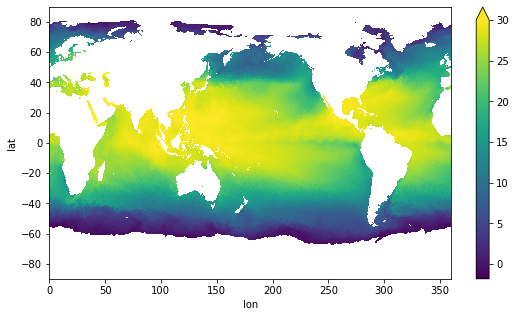

In [6]:
sst = xr.DataArray(df * 0.1, dims=["lat", "lon"], coords={"lat":lat, "lon":lon})
sst.plot(figsize=[9,5], vmin=-1.8, vmax=30)
plt.show()